In [ ]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2

Image shape is  (1360, 2037, 3)


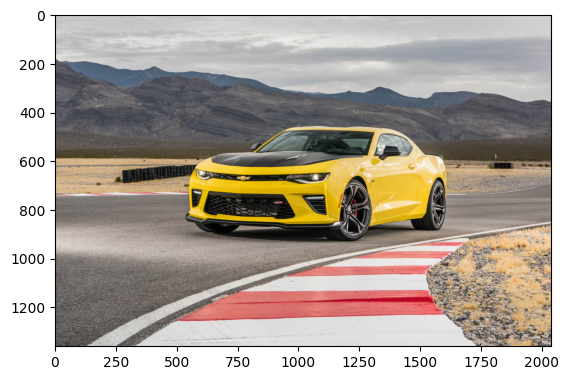

In [ ]:
img = cv2.imread("car.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Image shape is ", img.shape) #H, w, 3
plt.imshow(img)

In [23]:
transforms = T.Compose([T.ToPILImage(),
                        T.ToTensor()
                        ])

# Conv2d

In [36]:
# CNN layer expects input -> [batch_size, channels, height, width]

conv2d_layer = nn.Conv2d(in_channels=3,
                         out_channels=3,
                         kernel_size=3,
                         stride=1,
                         padding=1)

In [84]:
img_t = transforms(img)
output = conv2d_layer(img_t)

output.shape # [n, out_channels, H, W], if n=1 then [out_channels, H, W]

torch.Size([3, 1360, 2037])

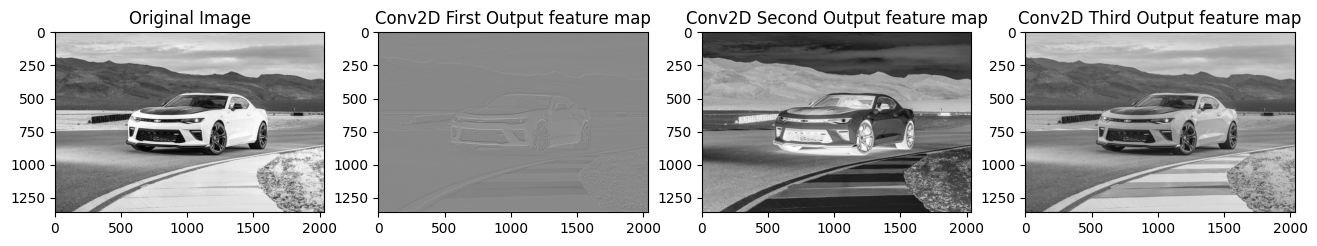

In [85]:
plt.figure(figsize=(16,12))

plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(img[0].detach(), cmap="gray")

plt.subplot(1,4,2)
plt.title("Conv2D First Output feature map")
plt.imshow(output[0].detach(), cmap="gray")

plt.subplot(1,4,3)
plt.title("Conv2D Second Output feature map")
plt.imshow(output[1].detach(), cmap="gray")

plt.subplot(1,4,4)
plt.title("Conv2D Third Output feature map")
plt.imshow(output[2].detach(), cmap="gray")

# ReLu

* ReLu(x) = Max(x, 0)
* if x < 0 -> 0
* If x > 0 -> X

* Without activation functions network becomes linear no matter how many layers we add
* CNN by itself cannot detect complex patterns 
* It only lears trivial information
* Non linearity helps it learn
    * Edges
    * Curves 
    * Textures 
    * Shapes
    * Complex Object Parts

* Before Relu, feature maps often contains negative values, noise, weak activations. 
* ReLu makes them cleaner, more interpretable and sparse (only meaningful patterns survive)

In [63]:
relu_output = torch.nn.functional.relu(output)
relu_output.shape

torch.Size([3, 1360, 2037])

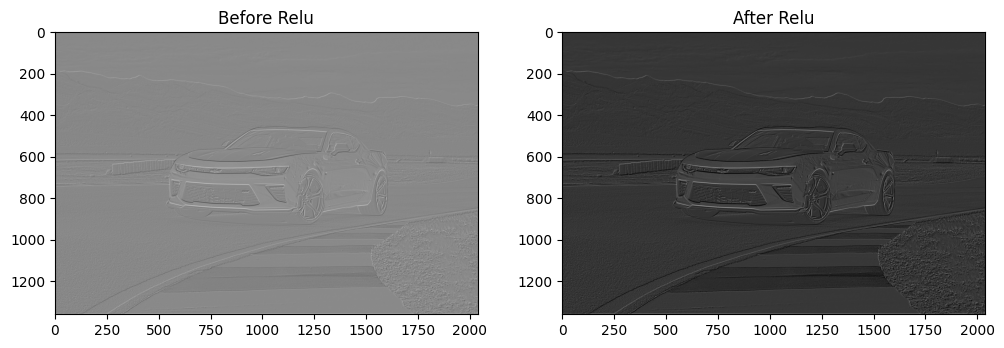

In [67]:
plt.figure(figsize=(12,8))

index = 0
plt.subplot(1,2,1)
plt.title("Before Relu")
plt.imshow(output[0].detach(), cmap="gray")

plt.subplot(1,2,2)
plt.title("After Relu")
plt.imshow(relu_output[0].detach(), cmap="gray")

* Before Relu image looks washed out and noisy
* Feature maps has both -ve and +ve values earlier
* Negative regions now become black 
* Only meaningful activations remain
* Edges and textures become more prominent 

* Relu is essentially a **Pattern Gate**

# Pooling

Pooling makes a CNN :- 

* translation-invariant
* computationally efficient
* able to detect patterns regardless of location
* fast to train
* less prone to overfitting

* Takes the maximum value from a region of pixels
* Keeps strongest features
* Removes weak/noisy values

In [ ]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)
pooled_output = pool(relu_output)
pooled_output.shape

torch.Size([3, 680, 1018])

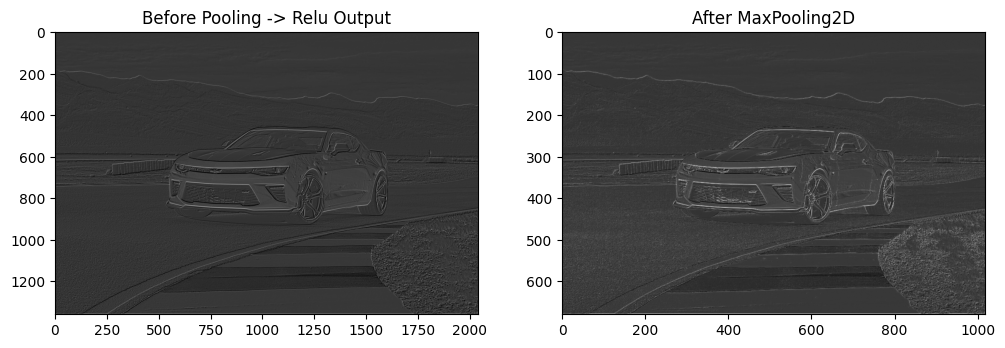

In [71]:
# As we can see from the output shape, the number of features seem to have been nearly halved

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.title("Before Pooling -> Relu Output")
plt.imshow(relu_output[0].detach(), cmap="gray")

plt.subplot(1,2,2)
plt.title("After MaxPooling2D")
plt.imshow(pooled_output[0].detach(), cmap="gray")

* Size becomes smaller from the previous feature maps
* Pattern becomes cleaner
* Only important activations remain
* Irrelevant noise is removed

Pooling is basically downsampling with **importance**

# Conv Block

* use_bn - batch normalization
* use_pool - whether to apply Maxpool2d after Relu
* pool_kernel - kernel size for pooling (stride = pool_kernel)
* drop_prob - dropout probability
* bias - if batchnorm is there no need for bias

In [81]:
#1

class ConvBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=8,
                 kernel_size=3, stride=1, padding=1,
                 use_bn=True, use_pool=True, 
                 pool_kernel=2, drop_prob=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=not use_bn)
        self.use_bn = use_bn 
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity() 
        self.relu = nn.ReLU(inplace=True)
        self.use_pool = use_pool 
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel) if use_pool else nn.Identity()
        self.drop_prop = drop_prob
        self.drop = nn.Dropout(drop_prob) if drop_prob>0 else nn.Identity()

    def forward(self, x, return_intermediate=False):
        conv_out = self.conv(x)
        bn_out = self.bn(conv_out)
        relu_out = self.relu(bn_out)
        pooled_out = self.pool(relu_out)
        dropped = self.drop(pooled_out)

        if return_intermediate:
            return {
                'conv':conv_out,
                'batch_norm':bn_out,
                'relu':relu_out,
                'Pooled':pooled_out,
                'out':dropped
            }
        return dropped

In [ ]:
block = ConvBlock()

input = img_t.unsqueeze(0)

inter = block(input, return_intermediate=True)
inter.keys()

out = block(input, return_intermediate=False)
out.shape

In [ ]:
#2 

class SimpleCnn(nn.Module):
    def __init__(self):
        super().__init__() #so child class SimpleCnn can use all the functionalities from inherited torch.nn.Module class 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(172212, 110) #Did hit and trial to get the matmul shapes correct
        self.fc2 = nn.Linear(110, 30)
        self.fc3 = nn.Linear(30, 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1) #Flatten all dimensions except Batch
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!**

In [111]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = SimpleCnn()

net = net.to(device)
net

SimpleCnn(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=172212, out_features=110, bias=True)
  (fc2): Linear(in_features=110, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
  (relu): ReLU(inplace=True)
)

In [112]:
img_t = img_t.to(device)
net(img_t)

tensor([[-0.0862,  0.1368],
        [-0.0817,  0.1416],
        [-0.0976,  0.1383],
        [-0.1042,  0.1299],
        [-0.1234,  0.1202],
        [-0.1234,  0.1202],
        [-0.1194,  0.1252],
        [-0.1234,  0.1202],
        [-0.1233,  0.1202],
        [-0.1233,  0.1202],
        [-0.1014,  0.1384],
        [-0.1230,  0.1209]], device='cuda:0', grad_fn=<AddmmBackward0>)